In [1]:
import sncosmo as sc
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import random
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from gaussian import *
from scipy.integrate import quad

### What I am trying to do:

In the PLAsTiCC paper (Kessler et al 2019), it is mentioned that the amplitude parameter of SALT2 model is being calculated using c, x1 and distance modulus parameter. The formula for this, as given in Scholnic and Kessler is mB = $\mu$ - $\alpha$ x1 + $\beta$ c + M and mB = -2.5 $\log_{10}$ (x0). Using this, i tried using definition of x0 = 10 $^{-0.4*(\mu - \alpha x1 + \beta c + M)}$ , but found a large difference between the lightcurves obtained from supernovae for which amplitude was set by this method and those for which amplitude was set using two different method (described in third code cell) and those generated in both ELAsTiCC and ELAsTiCC2 data samples. The following plots explain the difference. I'm trying to find out why this difference arises. 

In [2]:
# Read header and photometry files
# path = "/scratch/cprajakta/data/"
header = 'ELASTICC2_TRAIN_01_NONIaMODEL0-0001_HEAD.FITS'
photometry = 'ELASTICC2_TRAIN_01_NONIaMODEL0-0001_PHOT.FITS'
sne = sc.read_snana_fits(header, photometry) # sne has about 4200 supernovae

# Randomly choose a supernova that satisfies certain criteria described below
flag = False
i = random.randint(0, len(sne))
while flag == False:
    snanana = sne[i]
    z = snanana.meta['REDSHIFT_HELIO']
    # Redshifts for ELAsTiCC2 run till z = 3. z = 1.7 is roughly the limit till where original salt2 model gives data for lsst-i and r bands and also till where 
    # the extended model being used in this code works fine. Change the < sign to > to assess the changes in the behaviors of the model.
    if z > 1.7:
        vissne = snanana[snanana['SIM_MAGOBS'] != 99] # ignore datapoints that are flagged with SIM_MAGOBS = 99
        is_i = vissne[vissne['BAND'] == 'i ']
        simmagobs_i = is_i['SIM_MAGOBS']
        mjd_i = is_i['MJD']
        # Interpolate only if atleast 10 datapoints are present for chosen supernova. Else choose the next one. 
        # 10 datapoints is an arbitrary cutoff put to make sure the reliability of interpolation. 
        if len(mjd_i) > 10:
            fun_i = interp1d(mjd_i, simmagobs_i, kind='cubic')
            mjd_snana = np.arange(min(mjd_i), max(mjd_i), 1)
            imag_snana = fun_i(mjd_snana)
            peak_imjd_index = np.where(imag_snana == min(imag_snana))[0][0] # define the rough mjd at peak in i band to be the point where i band mag is the least
            # Pick this supernova only if there is atleast one data point available before the peak mjd to ensure the validity of the "peak" mjd. Else choose the next one. 
            if peak_imjd_index != 0: 
                t0 = mjd_snana[peak_imjd_index]
                flag = True
            else:
                i += 1
        else:
            i += 1
    else:
        i += 1

# Use these values of z and peak mjd found from above to simulate supernovae using sncosmo and parameters found through papers. 
print(t0, z, i)

60472.4021 2.8273215 961


/mnt/home/project/cprajakta/supernova/sncosmo/lib/python3.10/site-packages/sncosmo/models.py:189: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/mnt/home/project/cprajakta/supernova/sncosmo/lib/python3.10/site-packages/sncosmo/models.py:189: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


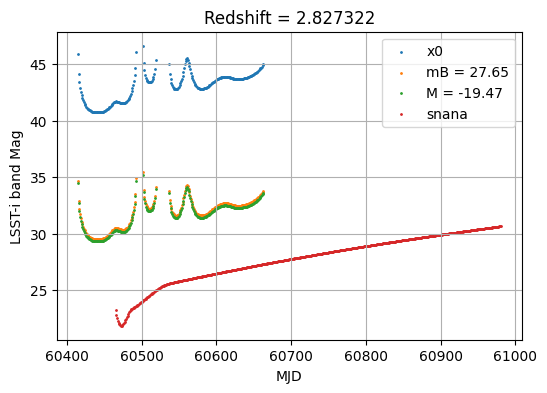

In [3]:
# Setting parameters

alpha = 0.14 # Betoule et al 2014
beta = 3.1 # Betoule et al 2014
cosmo = FlatLambdaCDM(H0=70*u.km/u.s/u.Mpc, Tcmb0=2.725*u.K, Om0=0.3)
source = sc.get_source('salt2-extended', version='1.0')

while True:
    x1 = asymgaus(0.973, 1.472, 0.222) # Scholnic and Kessler, Table 1, Var: G10, Survey: high z
    if -3 < x1 < 2: # ELAsTiCC github
        break
while True:
    c = asymgaus(-0.054, 0.043, 0.101) # Scholnic and Kessler, Table 1, Var: G10, Survey: high z
    if -0.3 < c < 0.5: # ELAsTiCC github
        break
while True:
    M = asymgaus(-19.35, 0.13, 0.13)  # Gaussian scatter on M, Kessler, communication on mail
    if -20 < M < -19:  # Not sure about this range
        break
plt.figure(figsize=(6, 4))
plt.grid(True)

# Trying to set the x0 parameter using three different methods allowed in sncosmo. 

""" 
1. set x0 amplitude directly. There is some descrepancy in the method of setting it because the lightcurve I get after setting the parameter this way dooesn't match with the 
other two methods and neither with SNANA simulated data. It gets solved if the x0 is set as x0 = 10**(-0.4*(mB-11)) instead of standard definition of x0 = 10**(-0.4*(mB)). 
But I'm not sure why this constant needs to be added. Please also note that all the parameters in this code block are drawn randomly from symmetric or asymmetric gaussian distributions, 
and thus how well these three lightcurves match with snana data should only be looked at keeping that randomness factor and its extend in mind. 
"""
dl = cosmo.luminosity_distance(z).value
mu = 5*np.log10(dl) + 25
mB = mu + M - alpha*x1 + beta*c
x0 = 10**(-0.4*(mB))
sn = sc.Model(source = source)
sn.set(z = z, t0 = t0, x0 = x0, x1 = x1, c = c)
mjd = np.arange(sn.mintime(), sn.maxtime(), 1)
imag = sn.bandmag('lssti', 'ab', mjd)
plt.scatter(mjd, imag, s=1, label='x0')

"""
2. Set amplitude via setting peak apparent magnitude in rest frame i band pass, mB. mB is defined above. 
"""
sn_ctrl = sc.Model(source = source)
sn_ctrl.set(z = z, t0 = t0, x1 = x1, c = c)
sn_ctrl.set_source_peakmag(mB, 'lssti', 'ab')
mjd_ctrl = np.arange(sn_ctrl.mintime(), sn_ctrl.maxtime(), 1)
imag_ctrl = sn_ctrl.bandmag('lssti', 'ab', mjd_ctrl)
plt.scatter(mjd_ctrl, imag_ctrl, s=1, label='mB = %.2f'%(mB))

"""
3. Set amplitude via setting peak absolute magnitude in rest frame i band pass, M. M is being drawn from a gaussian distribution above to take into account the intrisic supernova scatter. 
"""
sn_ctrl2 = sc.Model(source = source)
sn_ctrl2.set(z = z, t0 = t0, x1 = x1, c = c)
sn_ctrl2.set_source_peakabsmag(M, 'lssti', 'ab')
mjd_ctrl2 = np.arange(sn_ctrl2.mintime(), sn_ctrl2.maxtime(), 1)
imag_ctrl2 = sn_ctrl2.bandmag('lssti', 'ab', mjd_ctrl2)
plt.scatter(mjd_ctrl2, imag_ctrl2, s=1, label='M = %.2f'%(M))

# Plot SNANA data
plt.scatter(mjd_snana, imag_snana, s=1, label='snana')

plt.xlabel("MJD")
plt.ylabel("LSST-i band Mag")
plt.title('Redshift = %f'%(z))
plt.legend()
plt.show()


### Next part:
Comparing the behaviour of three different models for low and high redshifts (cutoff point is same z = 1.7). Taking same data from SNANA as above and simulating this time with salt2-extended and hsiao template that works for redshifts > 1.7. While doing this I noted that the lightcurves for low redshift supernovae match quite well, but those for high redshifts ones are not in accordance with each other. I'm trying to find why this is the case and essentially find out what model snana sims are using to get their lightcurves. 

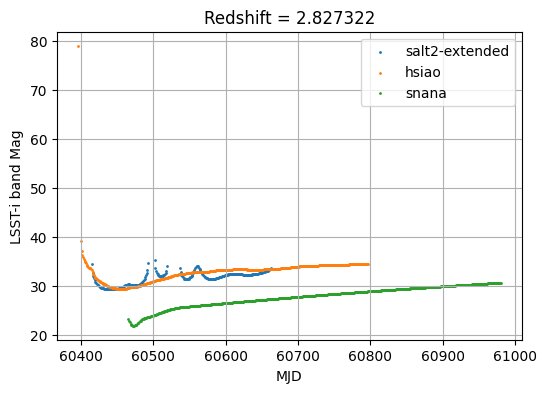

In [4]:
plt.figure(figsize=(6, 4))
plt.grid(True)
sn_salt2 = sc.Model(source = source)
sn_salt2.set(z = z, t0 = t0, x1 = x1, c = c)
sn_salt2.set_source_peakabsmag(M, 'lssti', 'ab')
mjd_salt2 = np.arange(sn_salt2.mintime(), sn_salt2.maxtime(), 1)
imag_salt2 = sn_salt2.bandmag('lssti', 'ab', mjd_salt2)
plt.scatter(mjd_salt2, imag_salt2, s=1, label='salt2-extended')

sn_hsiao = sc.Model(source = 'hsiao')
sn_hsiao.set(z = z, t0 = t0)
sn_hsiao.set_source_peakabsmag(M, 'lssti', 'ab')
mjd_hsiao = np.arange(sn_hsiao.mintime(), sn_hsiao.maxtime(), 1)
imag_hsiao = sn_hsiao.bandmag('lssti', 'ab', mjd_hsiao)
plt.scatter(mjd_hsiao, imag_hsiao, s=1, label='hsiao')

plt.scatter(mjd_snana, imag_snana, s=1, label='snana')
plt.xlabel("MJD")
plt.ylabel("LSST-i band Mag")
# plt.ylim(18, 36)
plt.title('Redshift = %f'%(z))
plt.legend()
plt.show()